# Approximate Bayesian Computation

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist
    !pip install pymc3==3.10
    !pip install arviz==0.11.0

In [2]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py

In [3]:
from utils import set_pyplot_params
set_pyplot_params()

This chapter introduces a method of last resort for the most complex problems, Approximate Bayesian Computation (ABC).
I say it is a last resort because it usually requires more computation than other methods, so if you can solve a problem any other way, you should.
However, for the examples in this chapter, ABC is not just easy to implement; it is also efficient.

The first example is my solution to a problem posed by a patient
with a kidney tumor.
I use data from a medical journal to model tumor growth, and use simulations to estimate the age of a tumor based on its size.

The second example is a model of cell counting, which has applications in biology, medicine, and zymurgy (beer-making).
Given a cell count from a diluted sample, we estimate the concentration of cells.

Finally, as an exercise, you'll have a chance to work on a fun sock-counting problem.


## The Kidney Tumor Problem

I am a frequent reader and occasional contributor to the online
statistics forum at <http://reddit.com/r/statistics>. 
In November 2011, I read the following message:

> "I have Stage IV Kidney Cancer and am trying to determine if the cancer formed before I retired from the military. ... Given the dates of retirement and detection is it possible to determine when there was a 50/50 chance that I developed the disease? Is it possible to determine the probability on the retirement date? My tumor was 15.5 cm x 15 cm at detection. Grade II."

I contacted the author of the message to get more information; I
learned that veterans get different benefits if it is "more likely than not" that a tumor formed while they were in military service (among other considerations).
So I agree to help him answer his question.

Because renal tumors grow slowly, and often do not cause symptoms, they are sometimes left untreated. As a result, doctors can observe the rate of growth for untreated tumors by comparing scans from the same patient at different times. Several papers have reported these growth rates.

For my analysis I used data from a paper by [Zhang et al](https://pubs.rsna.org/doi/full/10.1148/radiol.2501071712). 
They report growth rates in two forms:

* Volumetric doubling time, which is the time it would take for a tumor to double in size.

* Reciprocal doubling time (RDT), which is the number of doublings per year.

The next section shows how we work with these growth rates.

Zhang et al, Distribution of Renal Tumor Growth Rates Determined
    by Using Serial Volumetric CT Measurements, January 2009
    *Radiology*, 250, 137-144.
    
https://pubs.rsna.org/doi/full/10.1148/radiol.2501071712

## A Simple Growth Model

We'll start with a simple model of tumor growth based on two assumptions:

* Tumors grow with a constant doubling time, and 

* They are roughly spherical in shape.

And I'll define two points in time:

* `t1` is when my correspondent retired.

* `t2` is when the tumor was detected.

The time between `t1` and `t2` was about 9.0 years.
As an example, let's assume that the diameter of the tumor was 1 cm at `t1`, and estimate its size at `t2`.

I'll use the following function to compute the volume of a sphere with a given diameter.

In [4]:
import numpy as np

def calc_volume(diameter):
    """Converts a diameter to a volume."""
    factor = 4 * np.pi / 3
    return factor * (diameter/2.0)**3

Assuming that the tumor is spherical, we can compute its volume at `t1`.

In [5]:
d1 = 1
v1 = calc_volume(d1)
v1

0.5235987755982988

The median volume doubling time reported by Zhang et al. is 811 days, which corresponds to a reciprocal doubling time (RDT) of 0.45 doublings per year.

In [6]:
median_doubling_time = 811
rdt = 365 / median_doubling_time
rdt

0.45006165228113443

We can compute the number of doublings that would have happened in the interval between `t1` and `t2`:

In [7]:
interval = 9.0
doublings = interval * rdt
doublings

4.05055487053021

Given `v1` and the number of doublings, we can compute the volume at `t2`.

In [8]:
v2 = v1 * 2**doublings
v2

8.676351488087187

The following function computes the diameter of a sphere with the given volume.

In [9]:
def calc_diameter(volume):
    """Converts a volume to a diameter."""
    factor = 3 / np.pi / 4
    return 2 * (factor * volume)**(1/3)

So we can compute the diameter of the tumor at `t2`:

In [10]:
d2 = calc_diameter(v2)
d2

2.5494480788327483

If the diameter of the tumor was 1 cm at `t1`, and it grew at the median rate, the diameter would be about 2.5 cm at `t2`.

This example demonstrates the growth model, but it doesn't answer the question my correspondent posed.

## A More General Model

Given the size of a tumor at time of diagnosis, we would like to know the distribution of its age.
To find it, we'll run simulations of tumor growth to get the distribution of size conditioned on age. 
Then we'll compute the distribution of age conditioned on size.

The simulation starts with a small tumor and runs these steps:

1.  Choose a value from the distribution of growth rates.

2.  Compute the size of the tumor at the end of an interval.

3.  Repeat until the tumor exceeds the maximum relevant size.

So the first thing we need is the distribution of growth rates.

Using the figures in the paper by Zhange et al., I created an array, `rdt_sample`, that contains estimated values of RDT for the 53 patients in the study.

Again, RDT stands for "reciprocal doubling time", which is in doublings per year.
So if `rdt=1`, a tumor would double in volume in one year.
If `rdt=2`, it would double twice; that is, the volume would quadruple.
And if `rdt=-1`, it would halve in volume.

In [11]:
# Data from the histogram in Figure 3

import numpy as np
from empiricaldist import Pmf

counts = [2, 29, 11, 6, 3, 1, 1]
rdts = np.arange(-1, 6) + 0.01
pmf_rdt = Pmf(counts, rdts)
pmf_rdt.normalize()

53

In [12]:
# Data from the scatter plot in Figure 4

rdts = [5.089,  3.572,  3.242,  2.642,  1.982,  1.847,  1.908,  1.798,
        1.798,  1.761,  2.703, -0.416,  0.024,  0.869,  0.746,  0.257,
        0.269,  0.086,  0.086,  1.321,  1.052,  1.076,  0.758,  0.587,
        0.367,  0.416,  0.073,  0.538,  0.281,  0.122, -0.869, -1.431,
        0.012,  0.037, -0.135,  0.122,  0.208,  0.245,  0.404,  0.648,
        0.673,  0.673,  0.563,  0.391,  0.049,  0.538,  0.514,  0.404,
        0.404,  0.33,  -0.061,  0.538,  0.306]

rdt_sample = np.array(rdts)
len(rdt_sample)

53

We can use the sample of RDTs to estimate the PDF of the distribution.

In [13]:
from utils import kde_from_sample

qs = np.linspace(-2, 6, num=201)
pmf_rdt = kde_from_sample(rdt_sample, qs)

In [14]:
1 / pmf_rdt.median() * 365

651.7857142857142

Here's what it looks like.

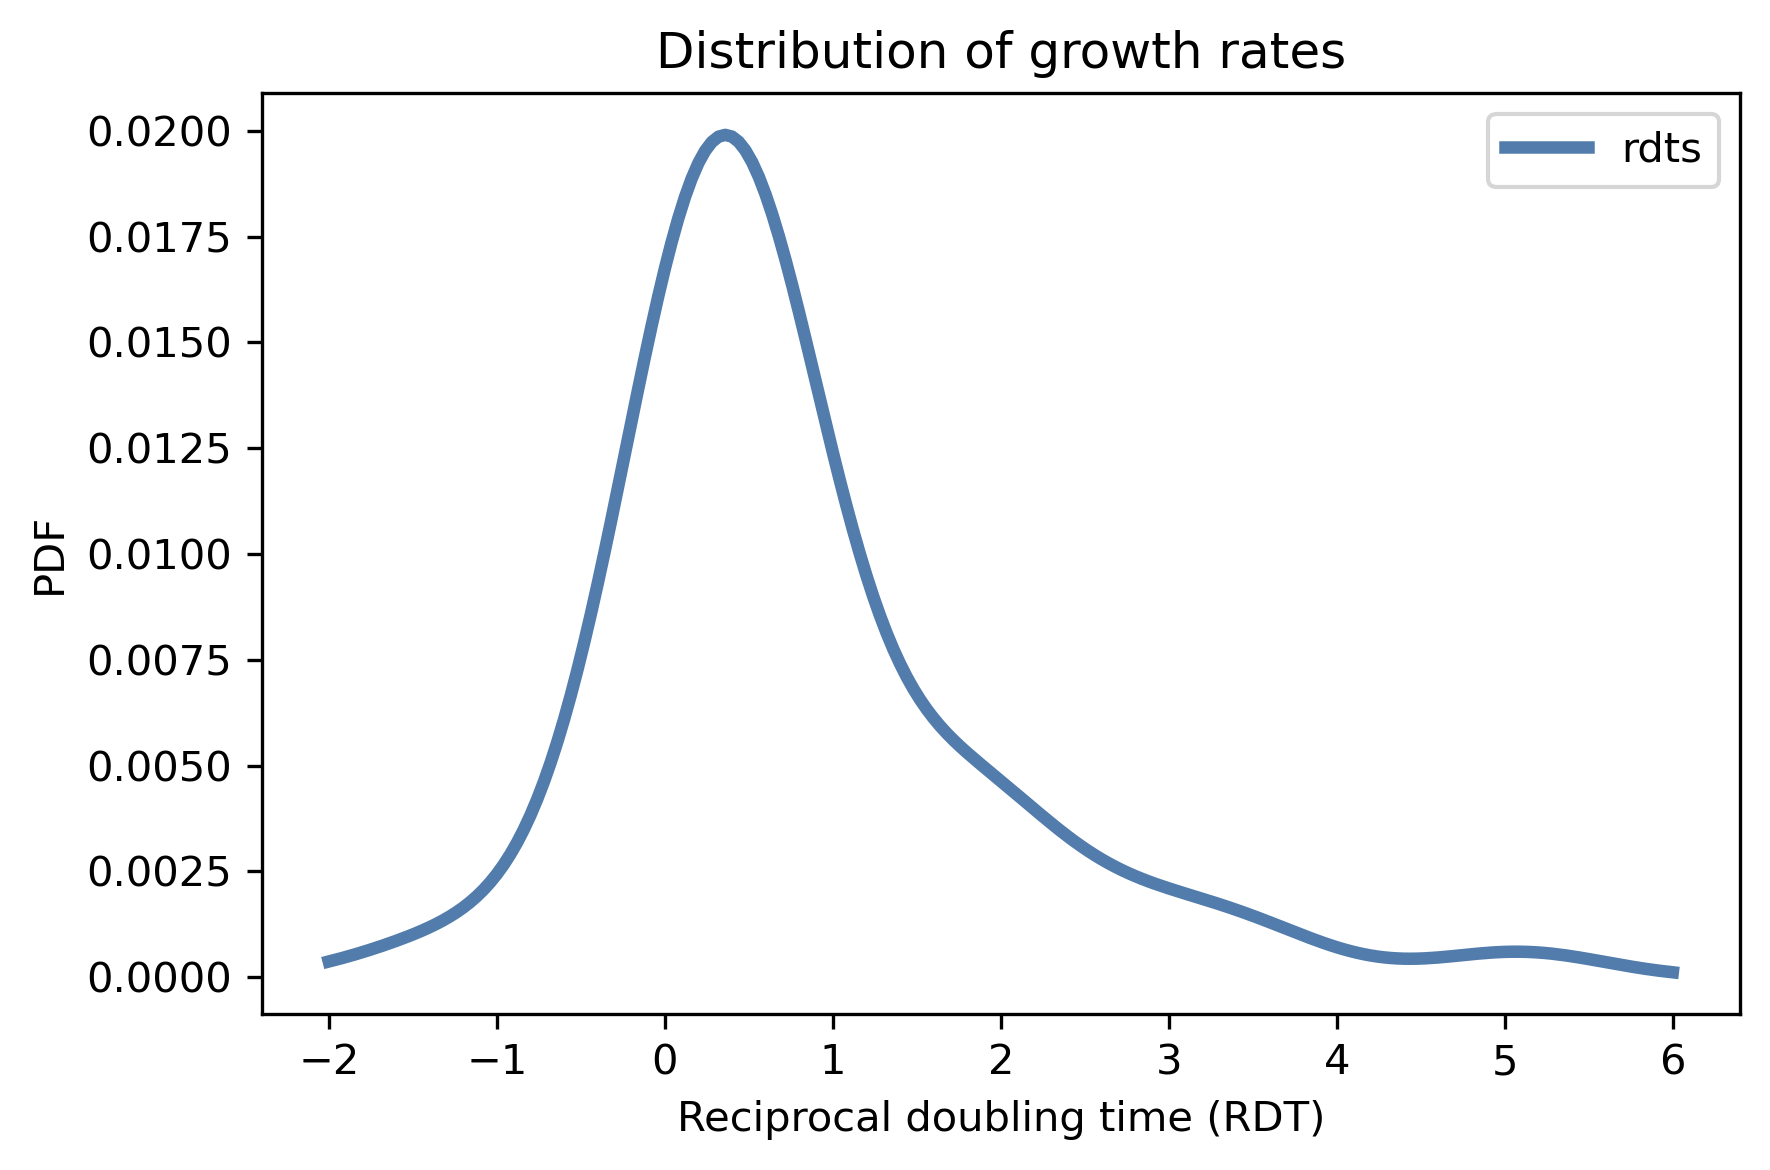

In [15]:
from utils import decorate

pmf_rdt.plot(label='rdts')

decorate(xlabel='Reciprocal doubling time (RDT)',
         ylabel='PDF',
         title='Distribution of growth rates')

In the next section we will use this distribution to simulate tumor growth. 

## Simulation

Now we're ready to run the simulations.
Starting with a small tumor, we'll simulate a series of intervals until the tumor reaches a maximum size.

At the beginning of each simulated interval, we'll choose a value from the distribution of growth rates and compute the size of the tumor at the end.

I chose an interval of 245 days (about 8 months) because that is the
median time between measurements in the data source

For the initial diameter I chose 0.3 cm, because carcinomas smaller than that are less likely to be invasive and less likely to have the blood supply needed for rapid growth (see [this page on carcinoma](http://en.wikipedia.org/wiki/Carcinoma_in_situ)).
For the maximum diameter I chose 20 cm. 

In [16]:
interval = 245 / 365      # year
min_diameter = 0.3        # cm
max_diameter = 20         # cm

I'll use `calc_volume` to compute the initial and maximum volumes:

In [17]:
v0 = calc_volume(min_diameter)
vmax = calc_volume(max_diameter)
v0, vmax

(0.014137166941154066, 4188.790204786391)

The following function runs the simulation.

In [18]:
import pandas as pd

def simulate_growth(pmf_rdt):
    """Simulate the growth of a tumor."""
    age = 0
    volume = v0
    res = []
    
    while True:
        res.append((age, volume))
        if volume > vmax:
            break

        rdt = pmf_rdt.choice()
        age += interval 
        doublings = rdt * interval
        volume *= 2**doublings
        
    columns = ['age', 'volume']
    sim = pd.DataFrame(res, columns=columns)
    sim['diameter'] = calc_diameter(sim['volume'])
    return sim

`simulate_growth` takes as a parameter a `Pmf` that represents the distribution of RDT.
It initializes the age and volume of the tumor, then runs a loop that simulates one interval at a time.

Each time through the loop, it checks the volume of the tumor and exits if it exceeds `vmax`.

Otherwise it chooses a value from `pmf_rdt` and updates `age` and `volume`.  Since `rdt` is in doublings per year, we multiply by `interval` to compute the number of doublings during each interval.

At the end of the loop, `simulate_growth` puts the results in a `DataFrame` and computes the diameter that corresponds to each volume.

Here's how we call this function:

In [19]:
np.random.seed(17)

In [20]:
sim = simulate_growth(pmf_rdt)

Here are the results for the first few intervals:

In [21]:
sim.head(3)

,age,volume,diameter
0,0.000000,0.014137,0.300000
1,0.671233,0.014949,0.305635
2,1.342466,0.019763,0.335441


And the last few intervals.

In [22]:
sim.tail(3)

,age,volume,diameter
43,28.863014,1882.067427,15.318357
44,29.534247,2887.563277,17.667603
45,30.205479,4953.618273,21.149883


To show the results graphically, I'll run 101 simulations:

In [23]:
np.random.seed(17)

In [24]:
sims = [simulate_growth(pmf_rdt) for _ in range(101)]

And plot the results.

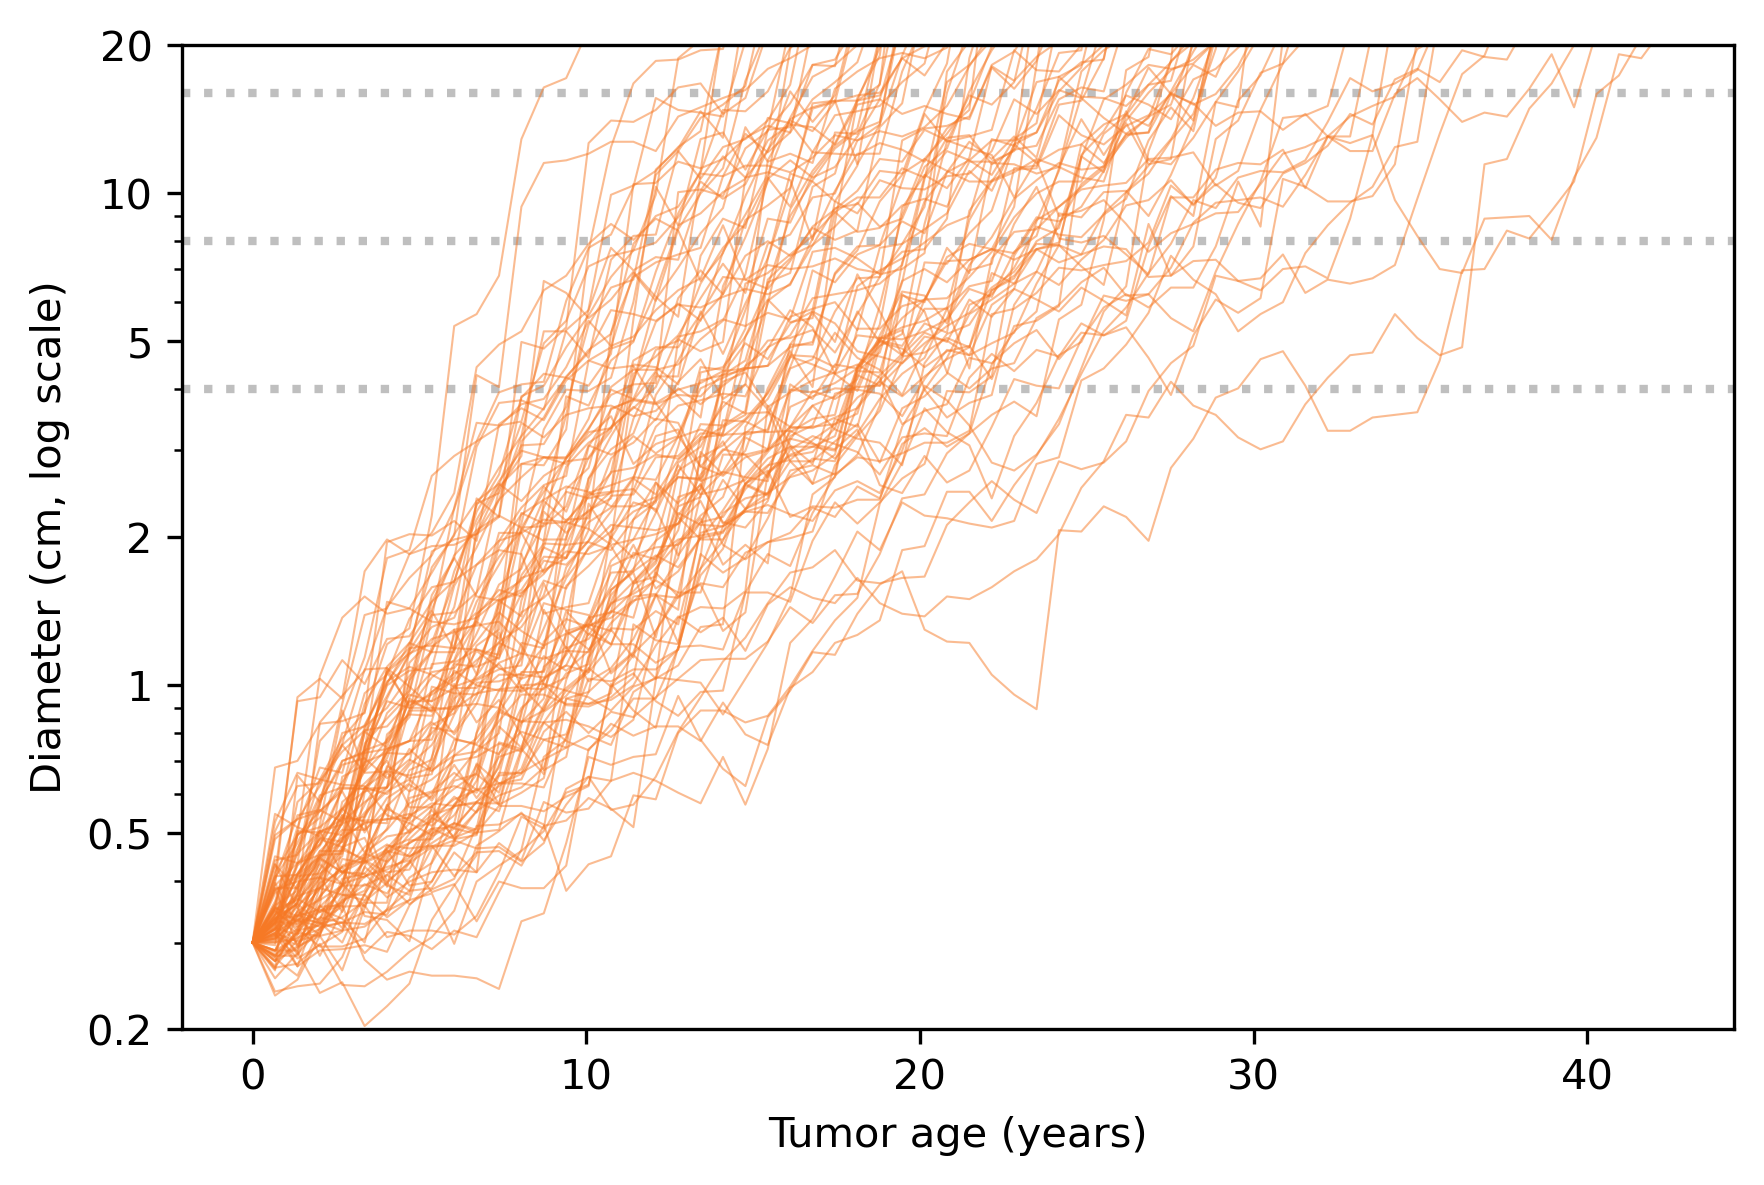

In [25]:
import matplotlib.pyplot as plt

diameters = [4, 8, 16]
for diameter in diameters:
    plt.axhline(diameter,
                color='C5', linewidth=2, linestyle='dotted')

for sim in sims:
    plt.plot(sim['age'], sim['diameter'],
             color='C1', linewidth=0.5, alpha=0.5)
    
decorate(xlabel='Tumor age (years)',
         ylabel='Diameter (cm, log scale)',
         ylim=[0.2, 20],
         yscale='log')

yticks = [0.2, 0.5, 1, 2, 5, 10, 20]
plt.yticks(yticks, yticks);

In this figure, each thin, solid line shows the simulated growth of a tumor over time, with diameter on a log scale.
The dotted lines are at 4, 8, and 16 cm.

By reading across the dotted lines, you can get a sense of the distribution of age at each size.
For example, reading across the top line, we see that the age of a 16 cm tumor might be as low 10 years or as high as 40 years, but it is most likely to be between 15 and 30.

To compute this distribution more precisely, we can interpolate the growth curves to see when each one passes through a given size.
The following function takes the results of the simulations and returns the age when each tumor reached a given diameter.

In [26]:
from scipy.interpolate import interp1d

def interpolate_ages(sims, diameter):
    """Estimate the age when each tumor reached a given size."""
    ages = []
    for sim in sims:
        interp = interp1d(sim['diameter'], sim['age'])
        age = interp(diameter)
        ages.append(float(age))
    return ages

We can call this function like this:

In [27]:
from empiricaldist import Cdf

ages = interpolate_ages(sims, 15)
cdf = Cdf.from_seq(ages)
print(cdf.median(), cdf.credible_interval(0.9))

22.31854530374061 [13.47056554 34.49632276]


For a tumor 15 cm in diameter, the median age is about 22 years, the 90% credible interval is between 13 and 34 years, and the probability that it formed less than 9 years ago is less than 1%.

In [28]:
1 - cdf(9.0)

0.9900990099009901

But this result is based on two modeling decisions that are potentially problematic:

* In the simulations, growth rate during each interval is independent of previous growth rates. In reality it is plausible that tumors that have grown quickly in the past are likely to grow quickly in the future. In other words, there is probably a serial correlation in growth rate.

* To convert from linear measure to volume, we assume that tumors are approximately spherical.

In additional experiments, I implemented a simulation that chooses growth rates with serial correlation; the effect is that the fast-growing tumors grow faster and the slow-growing tumors grow slower.
Nevertheless, with moderate correlation (0.5), the probability that a 15 cm tumor is less than 9 years old is only about 1%. 

The assumption that tumors are spherical is probably fine for tumors up to a few centimeters, but not for a tumor with linear dimensions 15.5 x 15 cm.
If, as seems likely, a tumor this size is relatively flat, it might have the same volume as a 6 cm sphere.
But even with this smaller volume and correlation 0.5, the probability that this tumor is less than 9 years old is about 5%.

So even taking into account modeling errors, it is unlikely that such a large tumor could have formed after my correspondent retired from military service.

The following figure shows the distribution of ages for tumors with diameters 4, 8, and 15 cm.

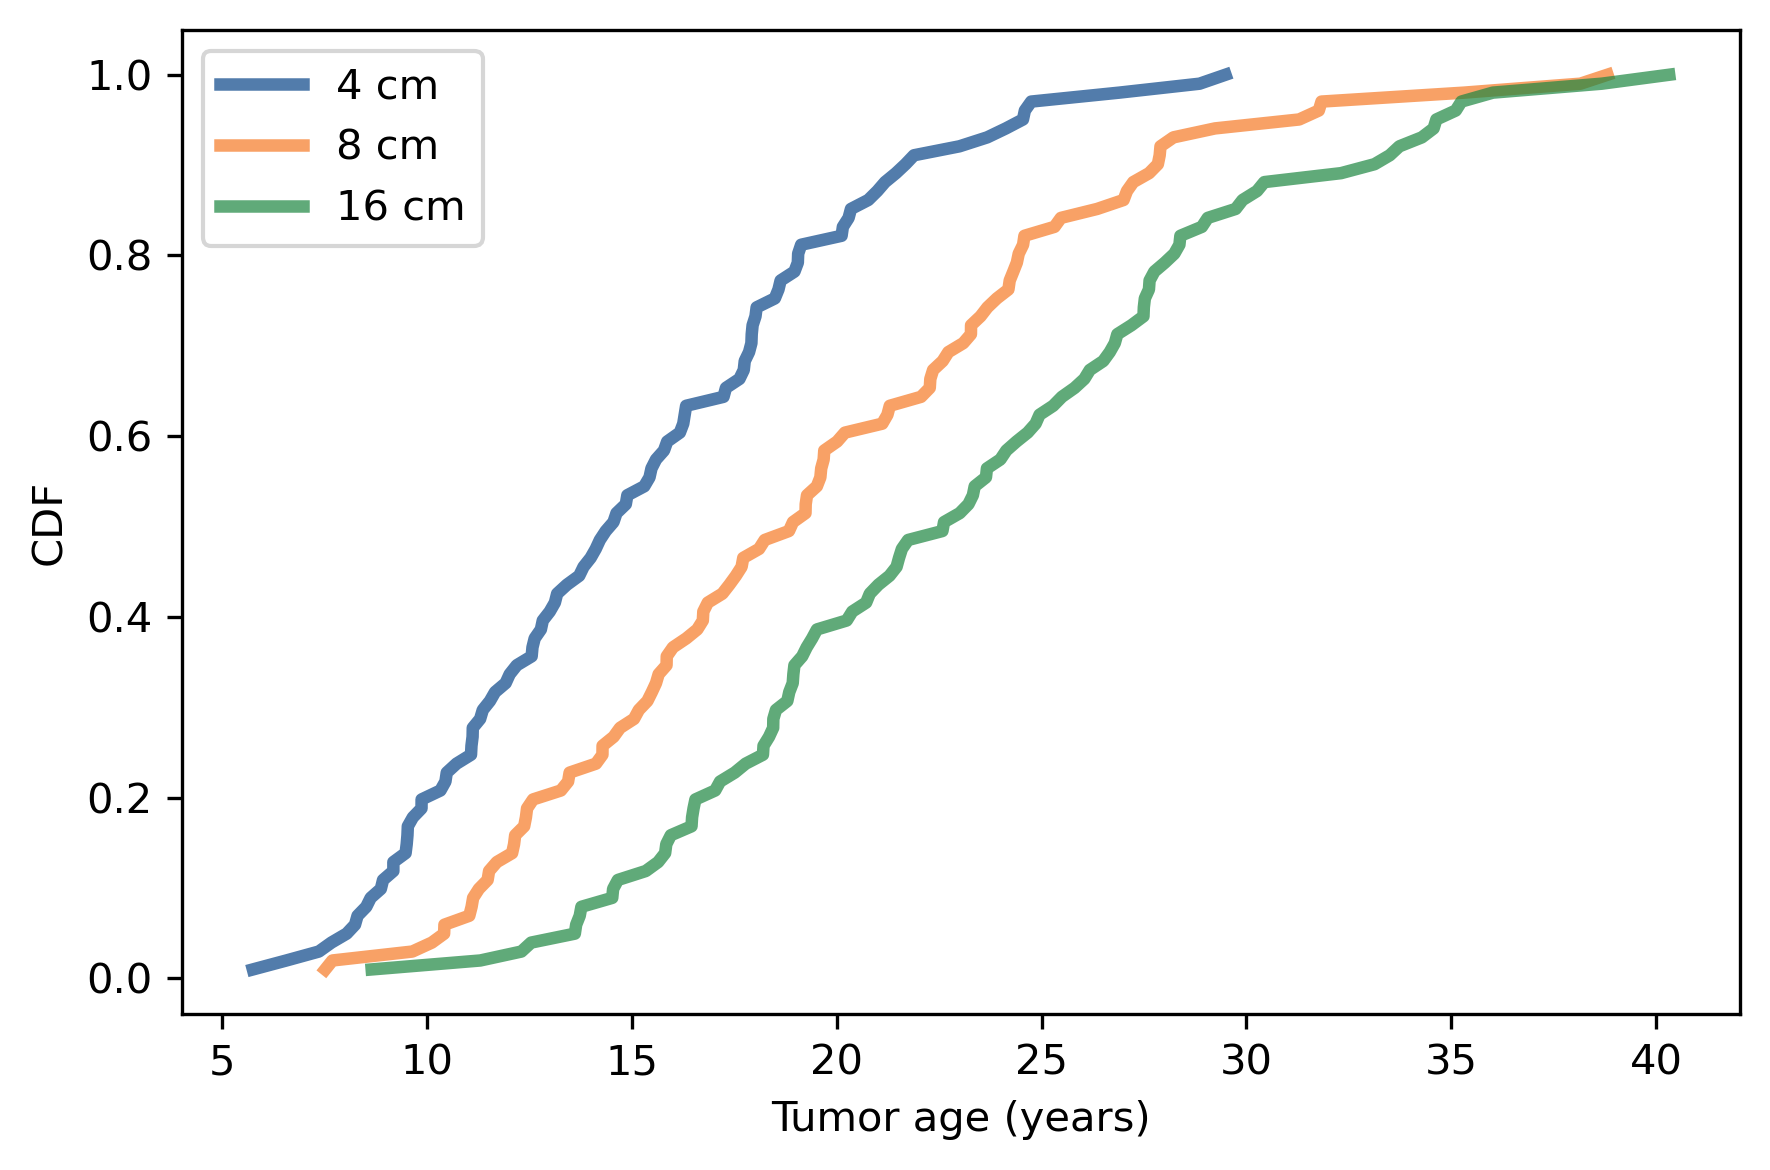

In [29]:
for diameter in diameters:
    ages = interpolate_ages(sims, diameter)
    cdf = Cdf.from_seq(ages)
    cdf.plot(label=f'{diameter} cm')
    
decorate(xlabel='Tumor age (years)',
         ylabel='CDF')

## Approximate Bayesian Calculation

At this point you might wonder why this example is in a book about Bayesian statistics.
We never defined a prior distribution or did a Bayesian update.
Why not? Because we didn't have to.

Instead, we used simulations to compute ages and sizes for a collection of hypothetical tumors.
Then, implicitly, we used the simulation results to form a joint distribution of age and size.
If we select a column from the joint distribution, we get a distribution of size conditioned on age.
If we select a row, we get a distribution of age conditioned on size.

So this example is like the ones we saw in <<_Probability>>: if you have all of the data, you don't need Bayes's theorem; you can compute probabilities by counting.

This example is a first step toward Approximate Bayesian Computation (ABC).
The next example is a second step.

## Counting Cells

This example comes from [this blog post](https://dataorigami.net/blogs/napkin-folding/bayesian-cell-counting), by Cameron Davidson-Pilon.
In it, he models the process biologists use to estimate the concentration of cells in a sample of liquid.
The example he presents is counting cells in a "yeast slurry", which is a mixture of yeast and water used in brewing beer.

There are two steps in the process:

* First, the slurry is diluted until the concentration is low enough that it is practical to count cells.

* Then a small sample is put on a hemocytometer, which is a specialized microscope slide that holds a fixed amount of liquid on a rectangular grid.

The cells and the grid are visible in a microscope, making it possible to count the cells accurately.

As an example, suppose we start with a yeast slurry with unknown concentration of cells.
Starting with a 1 mL sample, we dilute it by adding it to a shaker with 9 mL of water and mixing well.
Then we dilute it again, and then a third time.
Each dilution reduces the concentration by a factor of 10, so three dilutions reduces the concentration by a factor of 1000.

Then we add the diluted sample to the hemocytometer, which has a capacity of 0.0001 mL spread over a 5x5 grid.
Although the grid has 25 squares, it is standard practice to inspect only a few of them, say 5, and report the total number of cells in the inspected squares.

This process is simple enough, but at every stage there are sources of error:

* During the dilution process, liquids are measured using pipettes that introduce measurement error.

* The amount of liquid in the hemocytometer might vary from the specification.

* During each step of the sampling process, we might select more or less than the average number of cells, due to random variation.

Davidson-Pilon presents a PyMC model that describes these errors.
I'll start by replicating his model; then we'll adapt it for ABC.

Suppose there are 25 squares in the grid, we count 5 of them, and the total number of cells is 49.

In [30]:
total_squares = 25
squares_counted = 5
yeast_counted = 49

Here's the first part of the model, which defines the prior distribution of `yeast_conc`, which is the concentration of yeast we're trying to estimate.

`shaker1_vol` is the actual volume of water in the first shaker, which should be 9 mL, but might be higher or lower, with standard deviation 0.05 mL.
`shaker2_vol` and `shaker3_vol` are the volumes in the second and third shakers.

In [31]:
import pymc3 as pm
billion = 1e9

with pm.Model() as model:
    yeast_conc = pm.Normal("yeast conc", 
                           mu=2 * billion, sd=0.4 * billion)

    shaker1_vol = pm.Normal("shaker1 vol", 
                               mu=9.0, sd=0.05)
    shaker2_vol = pm.Normal("shaker2 vol", 
                               mu=9.0, sd=0.05)
    shaker3_vol = pm.Normal("shaker3 vol", 
                               mu=9.0, sd=0.05)

Now, the sample drawn from the yeast slurry is supposed to be 1 mL, but might be more or less.
And similarly for the sample from the first shaker and from the second shaker.
The following variables model these steps.

In [32]:
with model:
    yeast_slurry_vol = pm.Normal("yeast slurry vol",
                                    mu=1.0, sd=0.01)
    shaker1_to_shaker2_vol = pm.Normal("shaker1 to shaker2",
                                    mu=1.0, sd=0.01)
    shaker2_to_shaker3_vol = pm.Normal("shaker2 to shaker3",
                                    mu=1.0, sd=0.01)

Given the actual volumes in the samples and in the shakers, we can compute the effective dilution, `final_dilution`, which should be 1000, but might be higher or lower.

In [33]:
with model:
    dilution_shaker1 = (yeast_slurry_vol / 
                        (yeast_slurry_vol + shaker1_vol))
    dilution_shaker2 = (shaker1_to_shaker2_vol / 
                        (shaker1_to_shaker2_vol + shaker2_vol))
    dilution_shaker3 = (shaker2_to_shaker3_vol / 
                        (shaker2_to_shaker3_vol + shaker3_vol))
    
    final_dilution = (dilution_shaker1 * 
                      dilution_shaker2 * 
                      dilution_shaker3)

The next step is to place a sample from the third shaker in the chamber of the hemocytomer.
The capacity of the chamber should be 0.0001 mL, but might vary; to describe this variance, we'll use a gamma distribution, which ensures that we don't generate negative values.

In [34]:
with model:
    chamber_vol = pm.Gamma("chamber_vol", 
                           mu=0.0001, sd=0.0001 / 20)

On average, the number of cells in the chamber is the product of the actual concentration, final dilution, and chamber volume.
But the actual number might vary; we'll use a Poisson distribution to model this variance.

In [35]:
with model:
    yeast_in_chamber = pm.Poisson("yeast in chamber", 
        mu=yeast_conc * final_dilution * chamber_vol)

Finally, each cell in the chamber will be in one of the squares we count with probability `p=squares_counted/total_squares`.
So the actual count follows a binomial distribution.

In [36]:
with model:
    count = pm.Binomial("count", 
                        n=yeast_in_chamber, 
                        p=squares_counted/total_squares,
                        observed=yeast_counted)

With the model specified, we can use `sample` to generate a sample from the posterior distribution.

In [37]:
options = dict(return_inferencedata=False)

with model:
    trace = pm.sample(1000, **options)

Multiprocess sampling (2 chains in 2 jobs)


CompoundStep


>NUTS: [chamber_vol, shaker2 to shaker3, shaker1 to shaker2, yeast slurry vol, shaker3 vol, shaker2 vol, shaker1 vol, yeast conc]


>Metropolis: [yeast in chamber]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


The estimated number of effective samples is smaller than 200 for some parameters.


And we can use the sample to estimate the posterior distribution of `yeast_conc` and compute summary statistics.

In [38]:
posterior_sample = trace['yeast conc'] / billion
cdf_pymc = Cdf.from_seq(posterior_sample)
print(cdf_pymc.mean(), cdf_pymc.credible_interval(0.9))

2.2700608267545213 [1.86669531 2.72053704]


The posterior mean is about 2.3 billion cells per mL, with a 90% credible interval from 1.8 and 2.7.

So far we've been following in Davidson-Pilon's footsteps.
And for this problem, the solution using MCMC is sufficient.
But it also provides an opportunity to demonstrate ABC.

## Cell Counting With ABC

The fundamental idea of ABC is that we use the prior distribution to generate a sample of the parameters, and then simulate the system for each set of parameters in the sample.

In this case, since we already have a PyMC model, we can use `sample_prior_predictive` to do the sampling and the simulation.

In [39]:
with model:
    prior_sample = pm.sample_prior_predictive(10000)

The result is a dictionary that contains samples from the prior distribution of the parameters and the prior predictive distribution of count.

In [40]:
count = prior_sample['count']
print(count.mean())

39.9522


Now, to generate a sample from the posterior distribution, we'll select only the elements in the prior sample where the output of the simulation, `count`, matches the observed data, 49.

In [41]:
mask = (count == 49)
mask.sum()

250

We can use `mask` to select the values of `yeast_conc` for the simulations that yield the observed data.

In [42]:
posterior_sample2 = prior_sample['yeast conc'][mask] / billion

And we can use the posterior sample to estimate the CDF of the posterior distribution.

In [43]:
cdf_abc = Cdf.from_seq(posterior_sample2)
print(cdf_abc.mean(), cdf_abc.credible_interval(0.9))

2.2721642364350445 [1.85445095 2.68238424]


The posterior mean and credible interval are similar to what we got with MCMC.
Here's what the distributions look like.

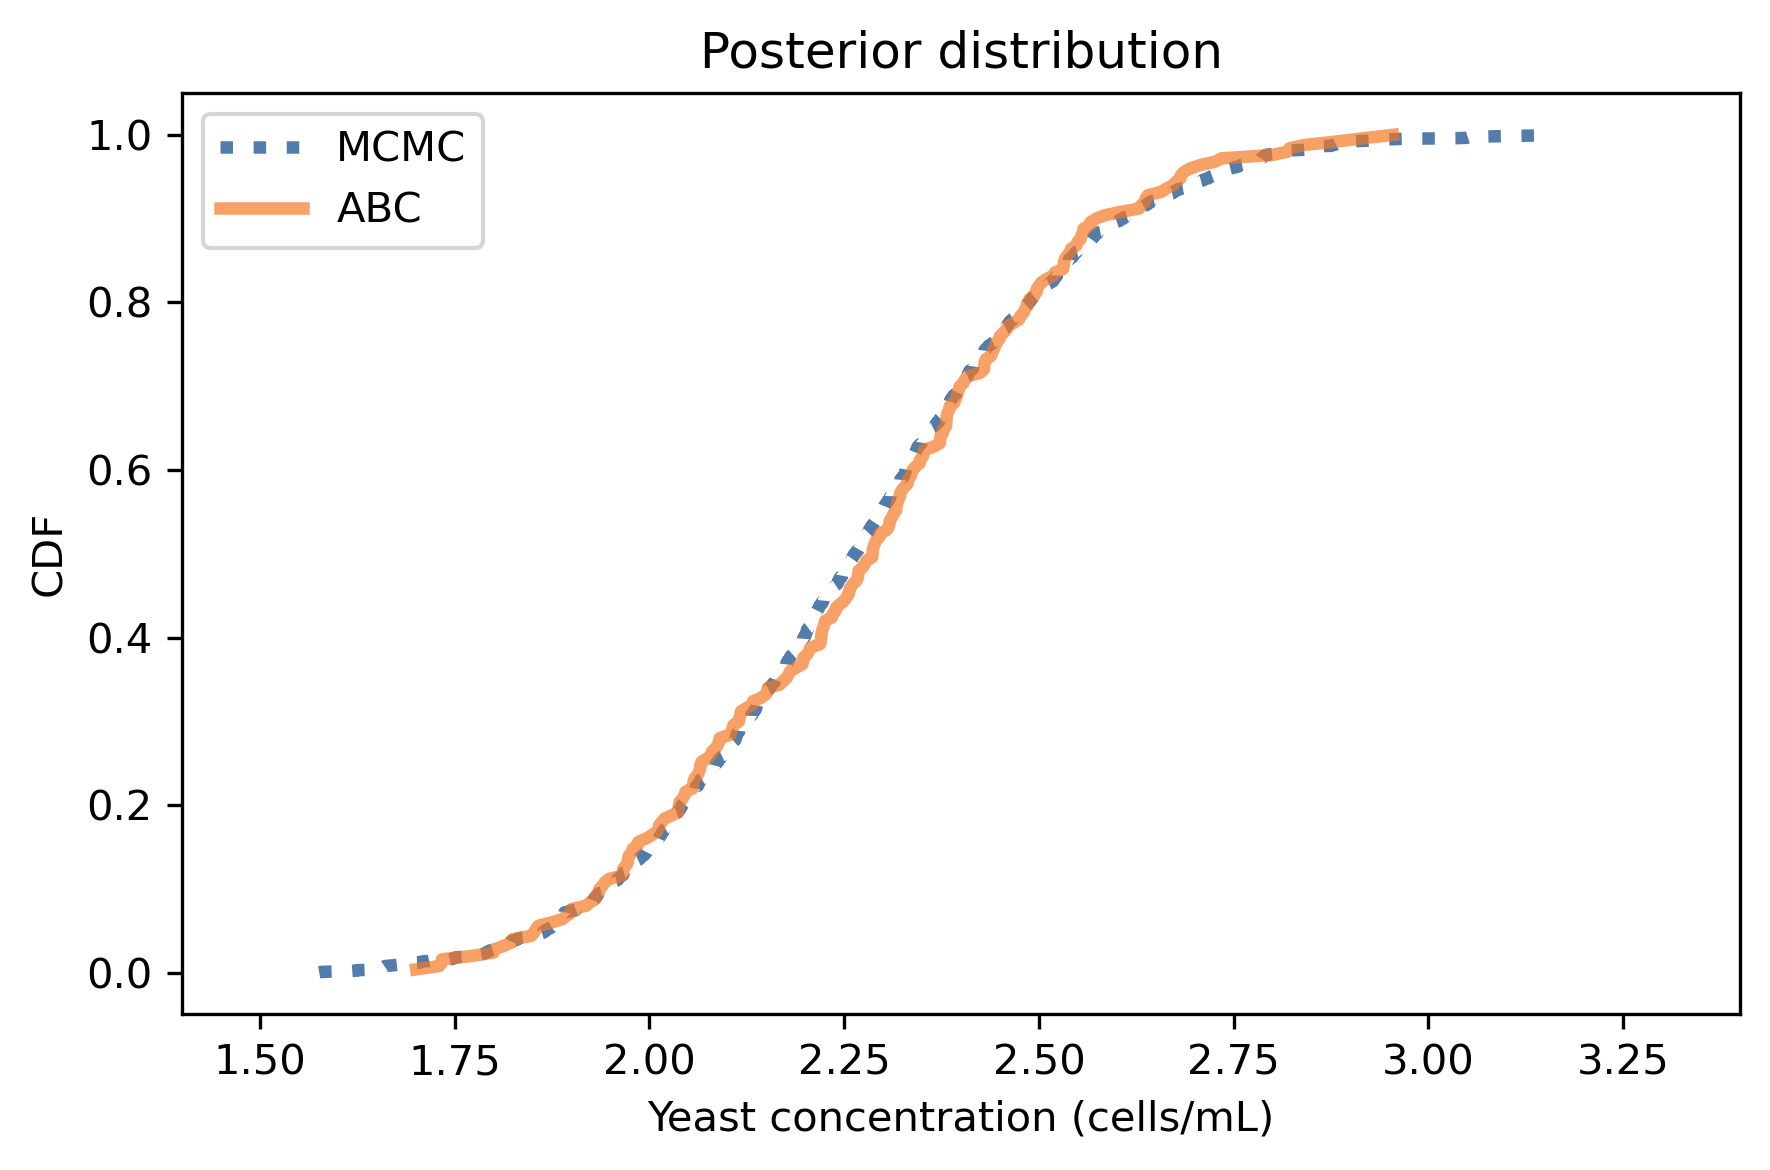

In [44]:
cdf_pymc.plot(label='MCMC', style=':')
cdf_abc.plot(label='ABC')

decorate(xlabel='Yeast concentration (cells/mL)',
         ylabel='CDF',
         title='Posterior distribution',
         xlim=(1.4, 3.4))

The distributions are similar, but the results from ABC are noisier because the sample size is smaller.

## When Do We Get To the Approximate Part?

The examples so far are similar to Approximate Bayesian Computation, but neither of them demonstrates all of the elements of ABC.
More generally, ABC is characterized by:

1. A prior distribution of parameters.

2. A simulation of the system that generates the data.

3. A criterion for when we should accept that the output of the simulation matches the data.

The kidney tumor example was atypical because we didn't represent the prior distribution of age explicitly.
Because the simulations generate a joint distribution of age and size, we we able to get the marginal posterior distribution of age directly from the results.

The yeast example is more typical because we represented the distribution of the parameters explicitly.
But we accepted only simulations where the output matches the data exactly.

The result is approximate in the sense that we have a sample from the posterior distribution rather than the posterior distribution itself.
But it is not approximate in the sense of Approximate Bayesian Computation, which typically accepts simulations where the output matches the data only approximately.

To show how that works, I will extend the yeast example with an approximate matching criterion.

In the previous section, we accepted a simulation if the output is precisely 49 and rejected it otherwise.
As a result, we got only a few hundred samples out of 10,000 simulations, so that's not very efficient.

We can make better use of the simulations if we give "partial credit" when the output is close to 49.
But how close?  And how much credit?

One way to answer that is to back up to the second-to-last step of the simulation, where we know the number of cells in the chamber, and we use the binomial distribution to generate the final count.

If there are `n` cells in the chamber, each has a probability `p` of being counted, depending on whether it falls in one of the squares in the grid that get counted.

We can extract `n` from the prior sample, like this:

In [45]:
n = prior_sample['yeast in chamber']
n.shape

(10000,)

And compute `p` like this:

In [46]:
p = squares_counted/total_squares
p

0.2

Now here's the idea: we'll use the binomial distribution to compute the likelihood of the data, `yeast_counted`, for each value of `n` and the fixed value of `p`.

In [47]:
from scipy.stats import binom

likelihood = binom(n, p).pmf(yeast_counted).flatten()

In [48]:
likelihood.shape

(10000,)

When the expected count, `n * p`, is close to the actual count, `likelihood` is relatively high; when it is farther away, `likelihood` is lower.

The following is a scatter plot of these likelihoods versus the expected counts.

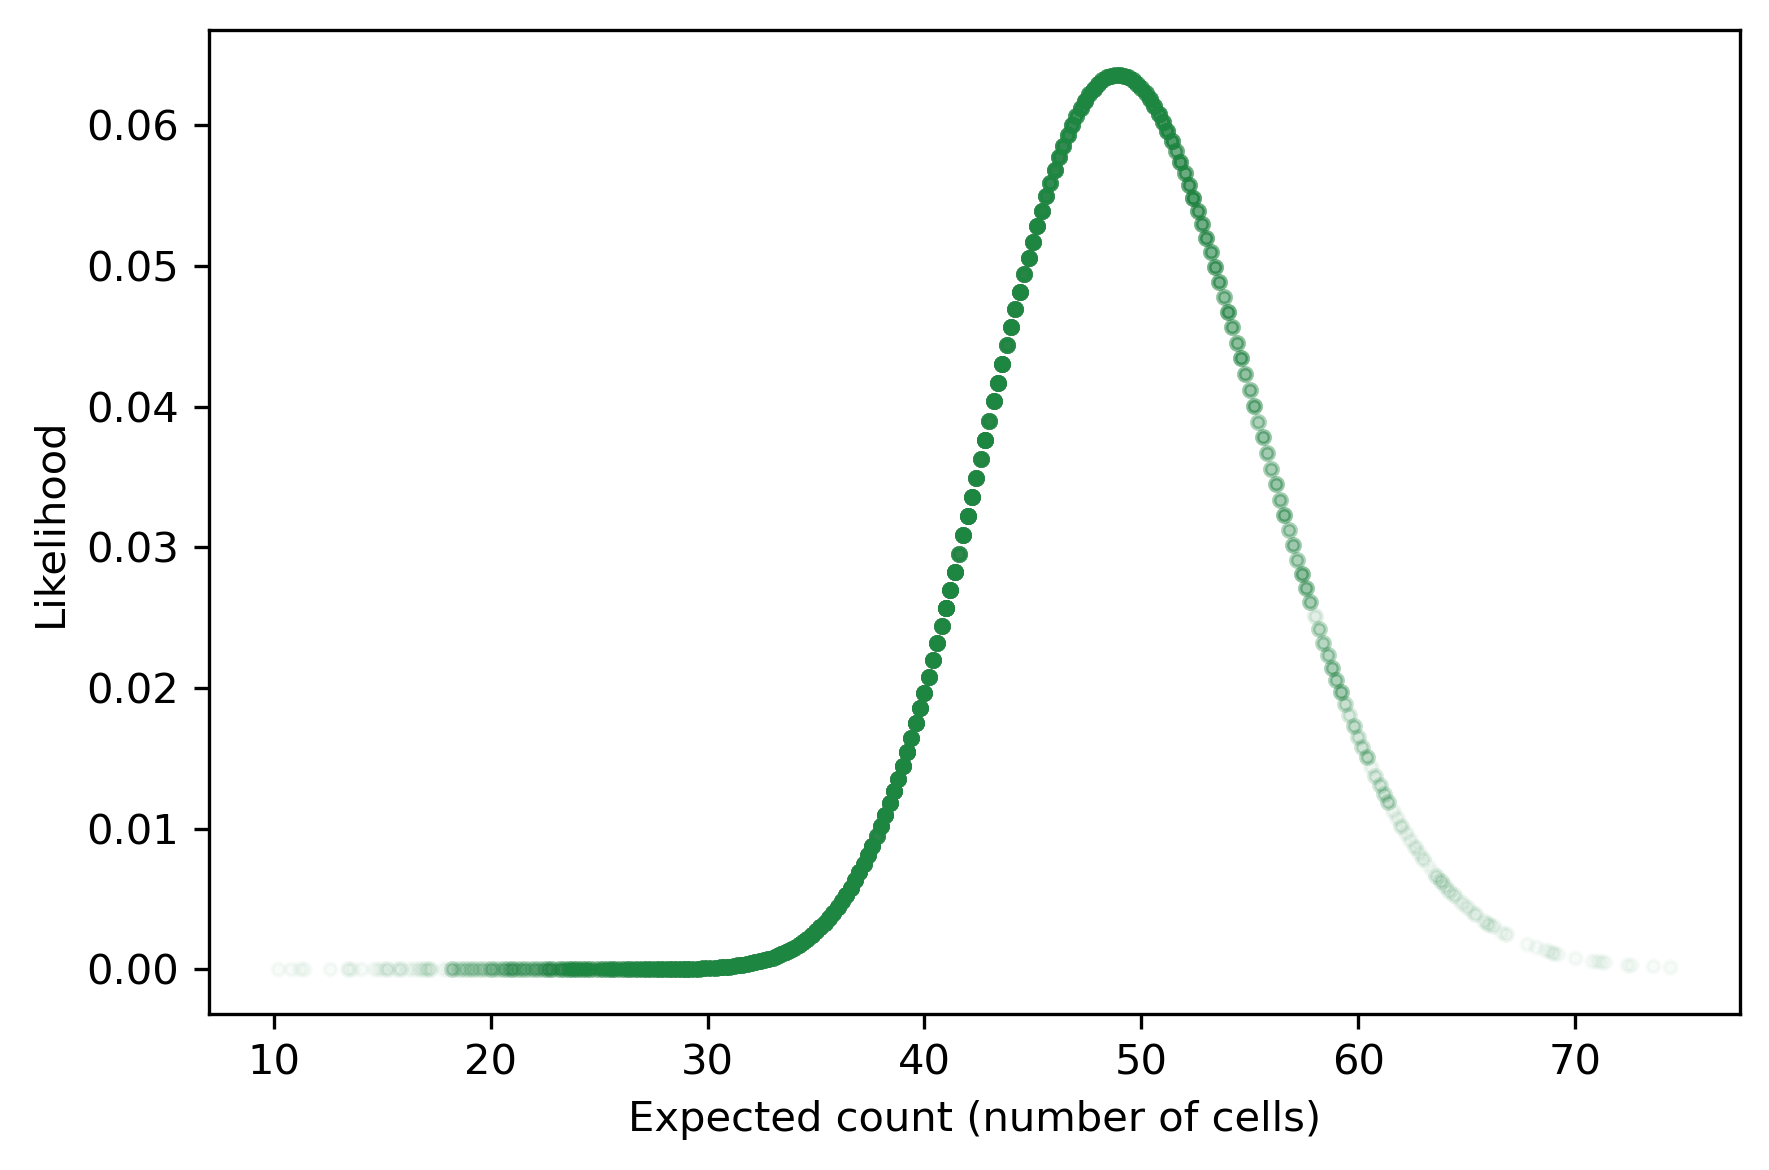

In [49]:
plt.plot(n*p, likelihood, '.', alpha=0.03, color='C2')

decorate(xlabel='Expected count (number of cells)',
         ylabel='Likelihood')

We can't use these likelihoods to do a Bayesian update because they are incomplete; that is, each likelihood is the probability of the data given `n`, which is the result of a single simulation.

But we *can* use them to weight the results of the simulations.
Instead of requiring the output of the simulation to match the data exactly, we'll use the likelihoods to give partial credit when the output is close.

Here's how: I'll construct a `Pmf` that contains yeast concentrations as quantities and the likelihoods as unnormalized probabilities.

In [50]:
qs = prior_sample['yeast conc'] / billion
ps = likelihood
posterior_pmf = Pmf(ps, qs)

In this `Pmf`, values of `yeast_conc` that yield outputs close to the data map to higher probabilities.
If we sort the quantities and normalize the probabilities, the result is an estimate of the posterior distribution.

In [51]:
posterior_pmf.sort_index(inplace=True)
posterior_pmf.normalize()

print(posterior_pmf.mean(), posterior_pmf.credible_interval(0.9)) 

2.271394162053131 [1.85344564 2.71299385]


The posterior mean and credible interval are similar to the values we got from MCMC.
And here's what the posterior distributions look like.

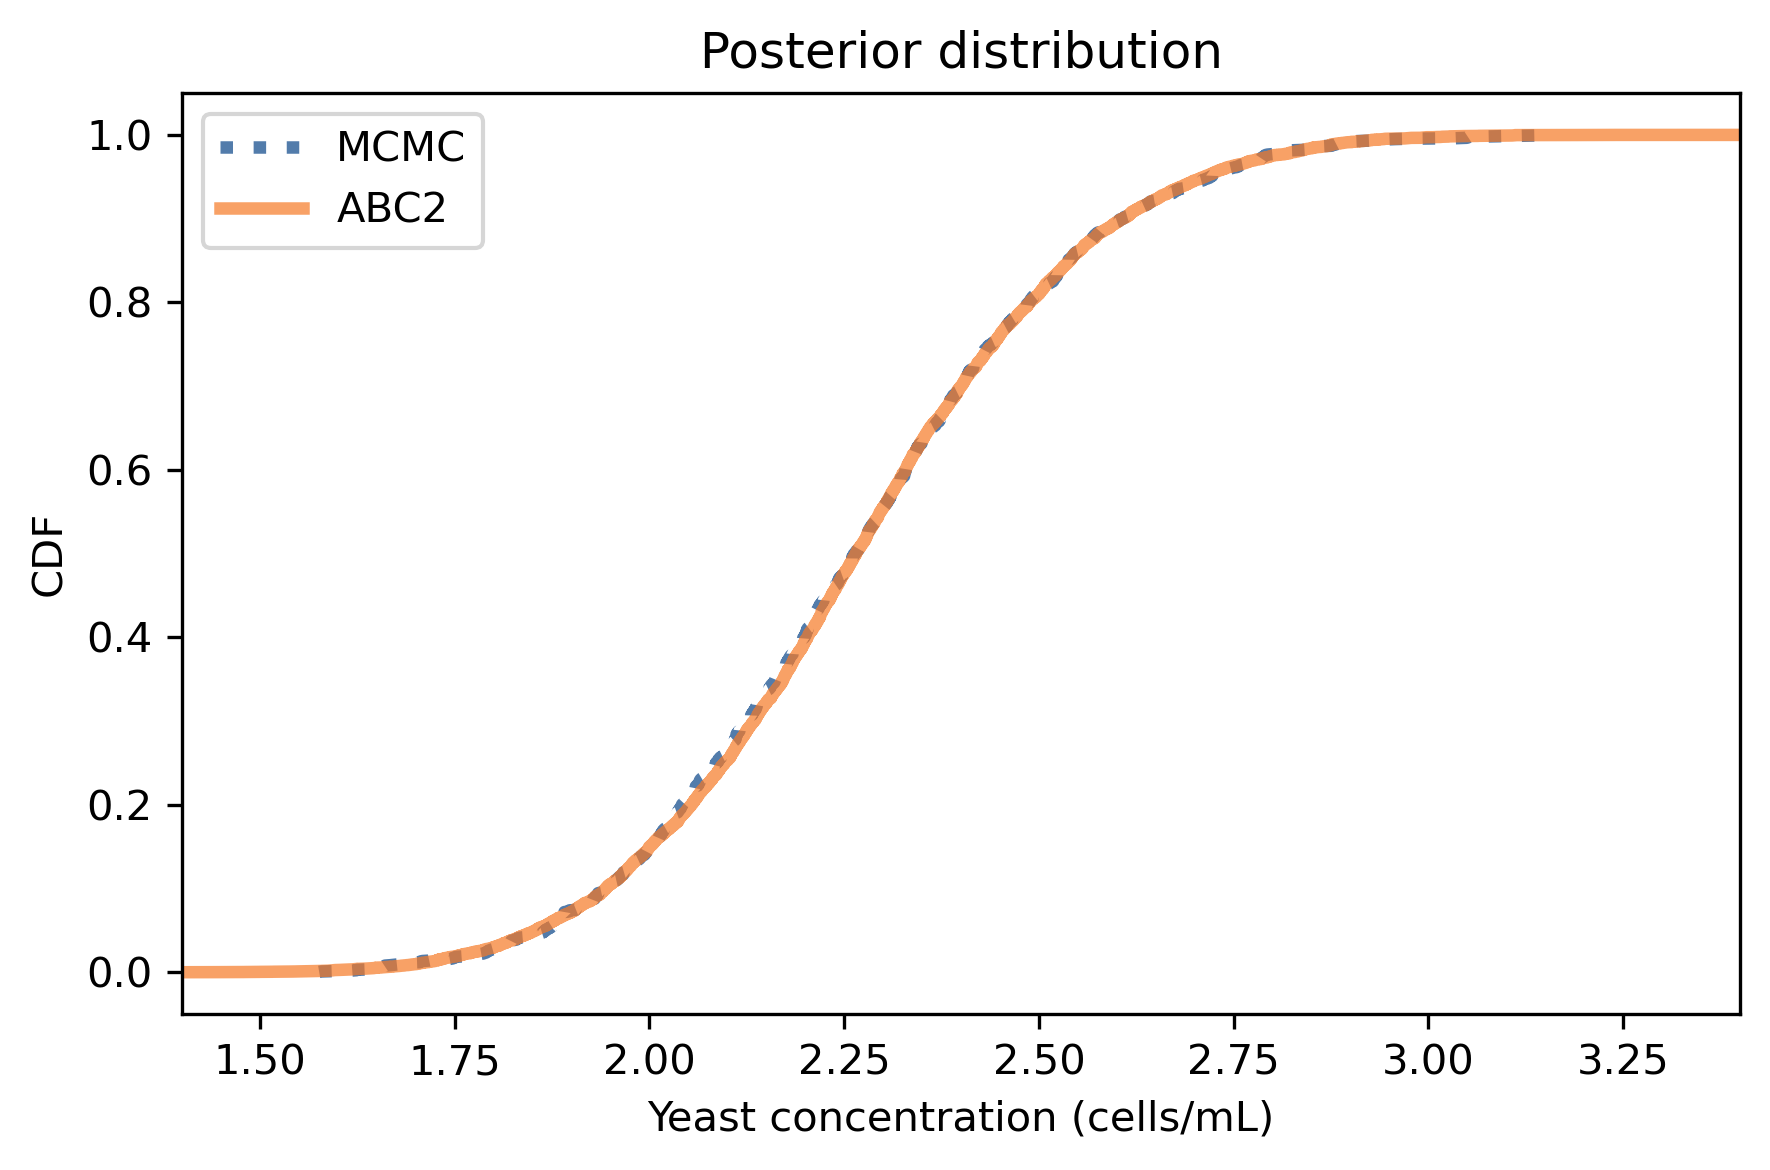

In [52]:
cdf_pymc.plot(label='MCMC', style=':')
#cdf_abc.plot(label='ABC')
posterior_pmf.make_cdf().plot(label='ABC2')

decorate(xlabel='Yeast concentration (cells/mL)',
         ylabel='CDF',
         title='Posterior distribution',
         xlim=(1.4, 3.4))

The distributions are similar, but the results from MCMC are a little noisier.
In this example, ABC is more efficient than MCMC, requiring less computation to generate a better estimate of the posterior distribution.
But that's unusual; usually ABC requires a lot of computation.
For that reason, it is generally a method of last resort.

## Summary

In this chapter we saw two examples of Approximate Bayesian Computation (ABC), based on simulations of tumor growth and cell counting.

The definitive elements of ABC are:

1. A prior distribution of parameters.

2. A simulation of the system that generates the data.

3. A criterion for when we should accept that the output of the simulation matches the data.

ABC is particularly useful when the system is too complex to model with tools like PyMC.
For example, it might involve a physical simulation based on differential equations.
In that case, each simulation might require substantial computation, and many simulations might be needed to estimate the posterior distribution.

Next, you'll have a chance to practice with one more example.

## Exercises

**Exercise:** This exercise is based on [a blog post by Rasmus Bååth](http://www.sumsar.net/blog/2014/10/tiny-data-and-the-socks-of-karl-broman), which is motivated by a tweet from Karl Broman, who wrote:

> That the first 11 socks in the laundry are distinct suggests that there are a lot of socks.

Suppose you pull 11 socks out of the laundry and find that no two of them make a matched pair.  Estimate the number of socks in the laundry.

To solve this problem, we'll use the model Bååth suggests, which is based on these assumptions:

* The laundry contains some number of pairs of socks, `n_pairs`, plus some number of odd (unpaired) socks, `n_odds`.

* The pairs of socks are different from each other and different from the unpaired socks; in other words, the number of socks of each type is either 1 or 2, never more.

We'll use the prior distributions Bååth suggests, which are:

* The number of socks follows a negative binomial distribution with mean 30 and standard deviation 15.

* The proportion of socks that are paired follows a beta distribution with parameters `alpha=15` and `beta=2`.

In the notebook for this chapter, I'll define these priors.  Then you can simulate the sampling process and use ABC to estimate the posterior distributions.

To get you started, I'll define the priors.

In [53]:
from scipy.stats import nbinom, beta

mu = 30
p = 0.8666666
r = mu * (1-p) / p

prior_n_socks = nbinom(r, 1-p)
prior_n_socks.mean(), prior_n_socks.std()

(29.999999999999996, 14.999996250001402)

In [54]:
prior_prop_pair = beta(15, 2)
prior_prop_pair.mean()

0.8823529411764706

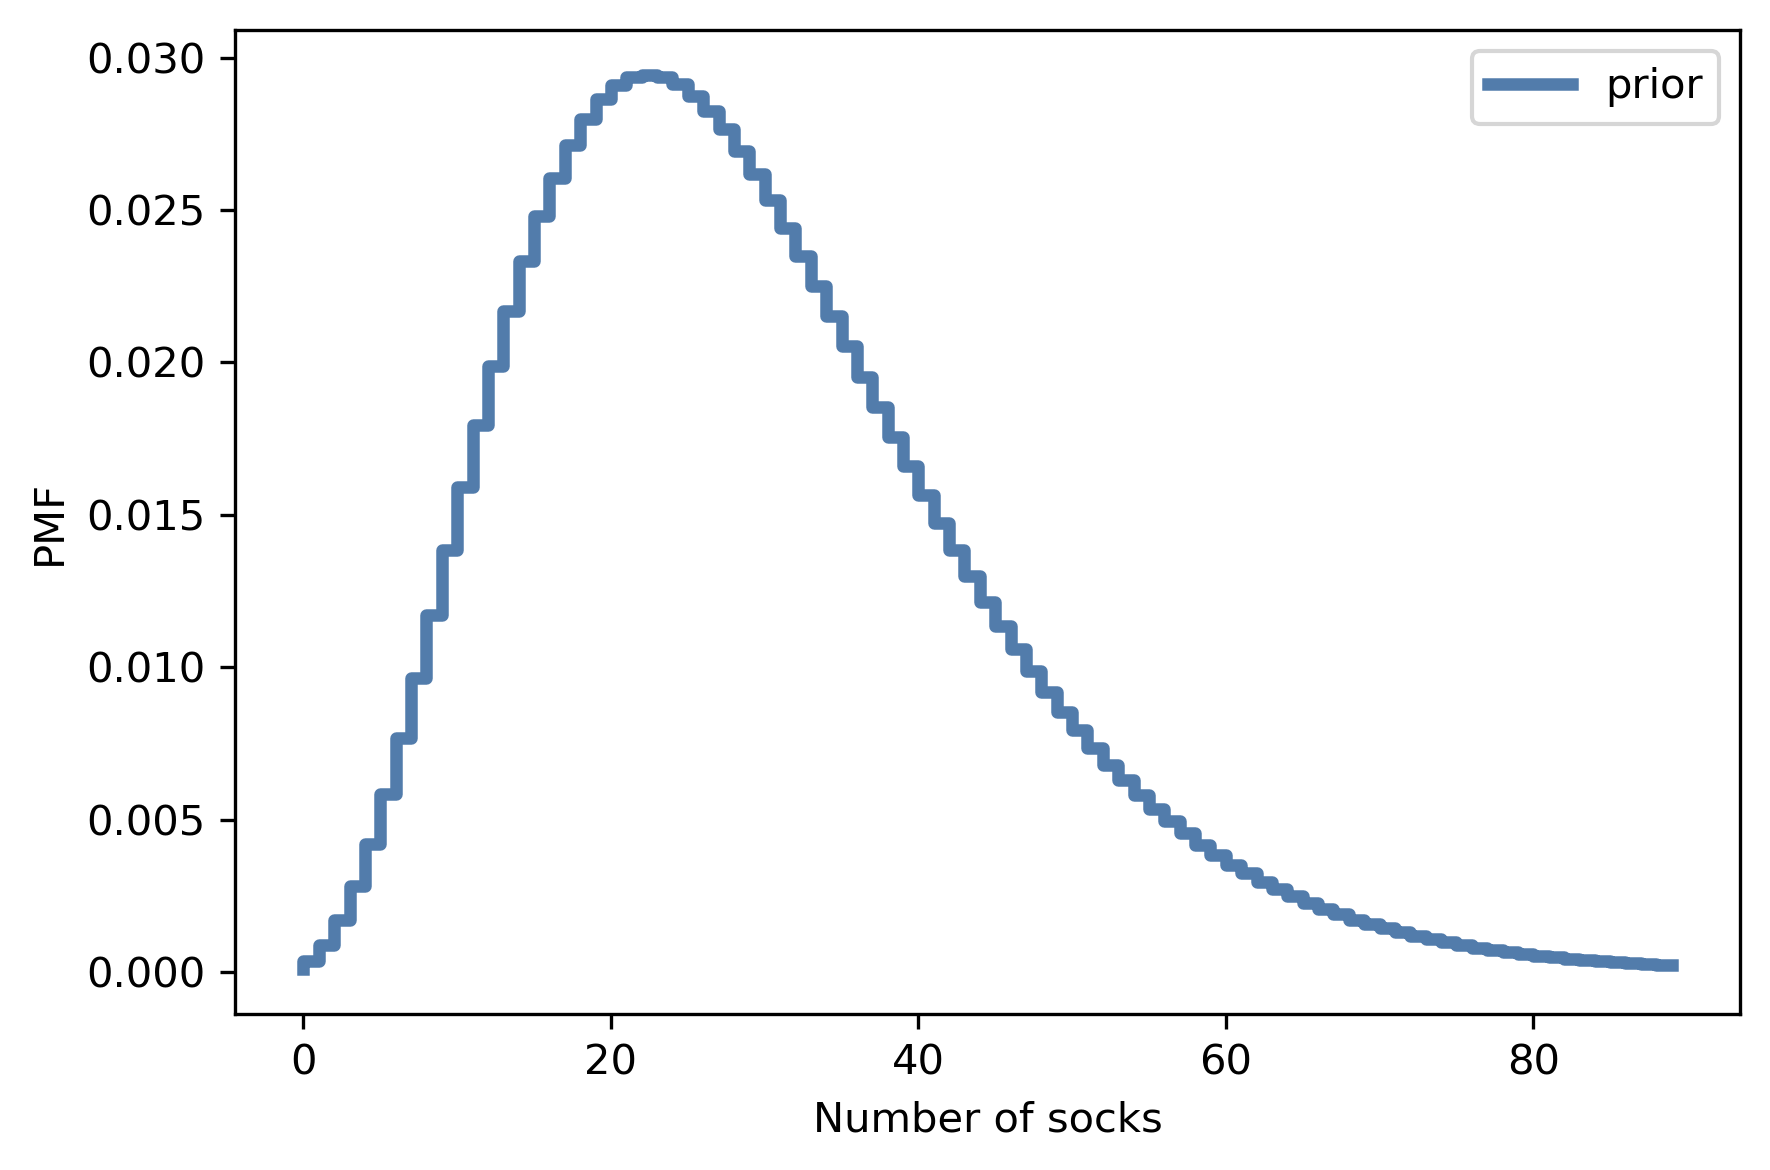

In [55]:
qs = np.arange(90)
ps = prior_n_socks.pmf(qs)
pmf = Pmf(ps, qs)
pmf.normalize()

pmf.plot(label='prior', drawstyle='steps')

decorate(xlabel='Number of socks',
         ylabel='PMF')

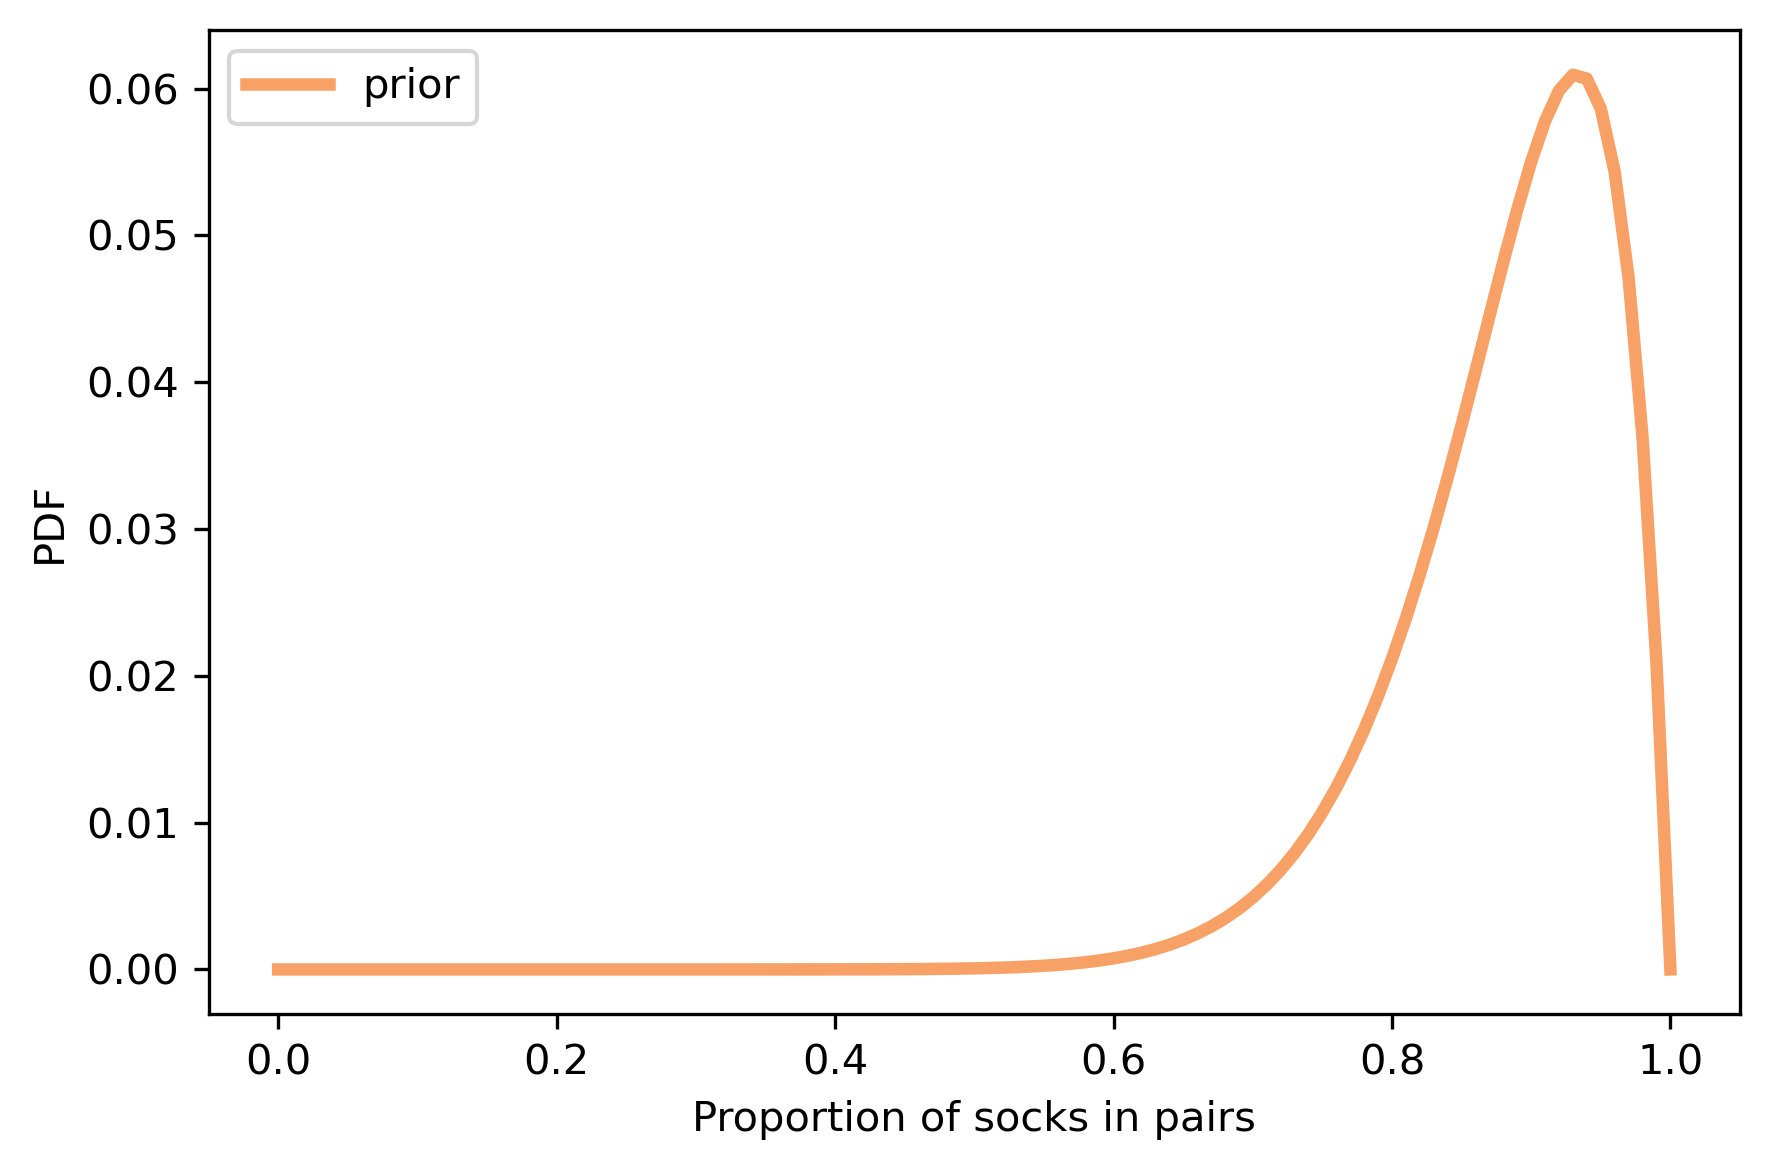

In [56]:
from utils import pmf_from_dist

qs = np.linspace(0, 1, 101)
pmf = pmf_from_dist(prior_prop_pair, qs)
pmf.plot(label='prior', color='C1')

decorate(xlabel='Proportion of socks in pairs',
         ylabel='PDF')

We can sample from the prior distributions like this:

In [57]:
n_socks = prior_n_socks.rvs()
prop_pairs = prior_prop_pair.rvs()

n_socks, prop_pairs

(28, 0.9645351561589227)

And use the values to compute `n_pairs` and `n_odds`:

In [58]:
n_pairs = np.round(n_socks//2 * prop_pairs)
n_odds = n_socks - n_pairs*2

n_pairs, n_odds

(14.0, 0.0)

Now you take it from there.

In [59]:
# Solution

n_pairs = 9
n_odds = 5

socks = np.append(np.arange(n_pairs), 
                  np.arange(n_pairs + n_odds))

print(socks)

[ 0  1  2  3  4  5  6  7  8  0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [60]:
# Solution

picked_socks = np.random.choice(socks, size=11, replace=False)
picked_socks

array([12, 11,  2,  1,  4,  8,  8,  0,  1,  0,  7])

In [61]:
# Solution

values, counts = np.unique(picked_socks, return_counts=True)
values

array([ 0,  1,  2,  4,  7,  8, 11, 12])

In [62]:
# Solution

counts

array([2, 2, 1, 1, 1, 2, 1, 1])

In [63]:
# Solution

solo = np.sum(counts==1)
pairs = np.sum(counts==2)

solo, pairs

(5, 3)

In [64]:
# Solution

def pick_socks(n_pairs, n_odds, n_pick):
    socks = np.append(np.arange(n_pairs), 
                      np.arange(n_pairs + n_odds))
    
    picked_socks = np.random.choice(socks, 
                                    size=n_pick, 
                                    replace=False)
    
    values, counts = np.unique(picked_socks, 
                               return_counts=True)
    pairs = np.sum(counts==2)
    odds = np.sum(counts==1)
    return pairs, odds

In [65]:
# Solution

pick_socks(n_pairs, n_odds, 11)

(2, 7)

In [66]:
# Solution

data = (0, 11)
res = []
for i in range(10000):
    n_socks = prior_n_socks.rvs()
    if n_socks < 11:
        continue
    prop_pairs = prior_prop_pair.rvs()
    n_pairs = np.round(n_socks//2 * prop_pairs)
    n_odds = n_socks - n_pairs*2
    result = pick_socks(n_pairs, n_odds, 11)
    if result == data:
        res.append((n_socks, n_pairs, n_odds))

len(res)

1157

In [67]:
# Solution

columns = ['n_socks', 'n_pairs', 'n_odds']
results = pd.DataFrame(res, columns=columns)
results.head()

,n_socks,n_pairs,n_odds
0,56,25.0,6.0
1,48,21.0,6.0
2,23,10.0,3.0
3,30,13.0,4.0
4,35,14.0,7.0


In [68]:
# Solution

qs = np.arange(15, 100)
posterior_n_socks = Pmf.from_seq(results['n_socks'])
print(posterior_n_socks.median(),
      posterior_n_socks.credible_interval(0.9))

44.0 [27. 74.]


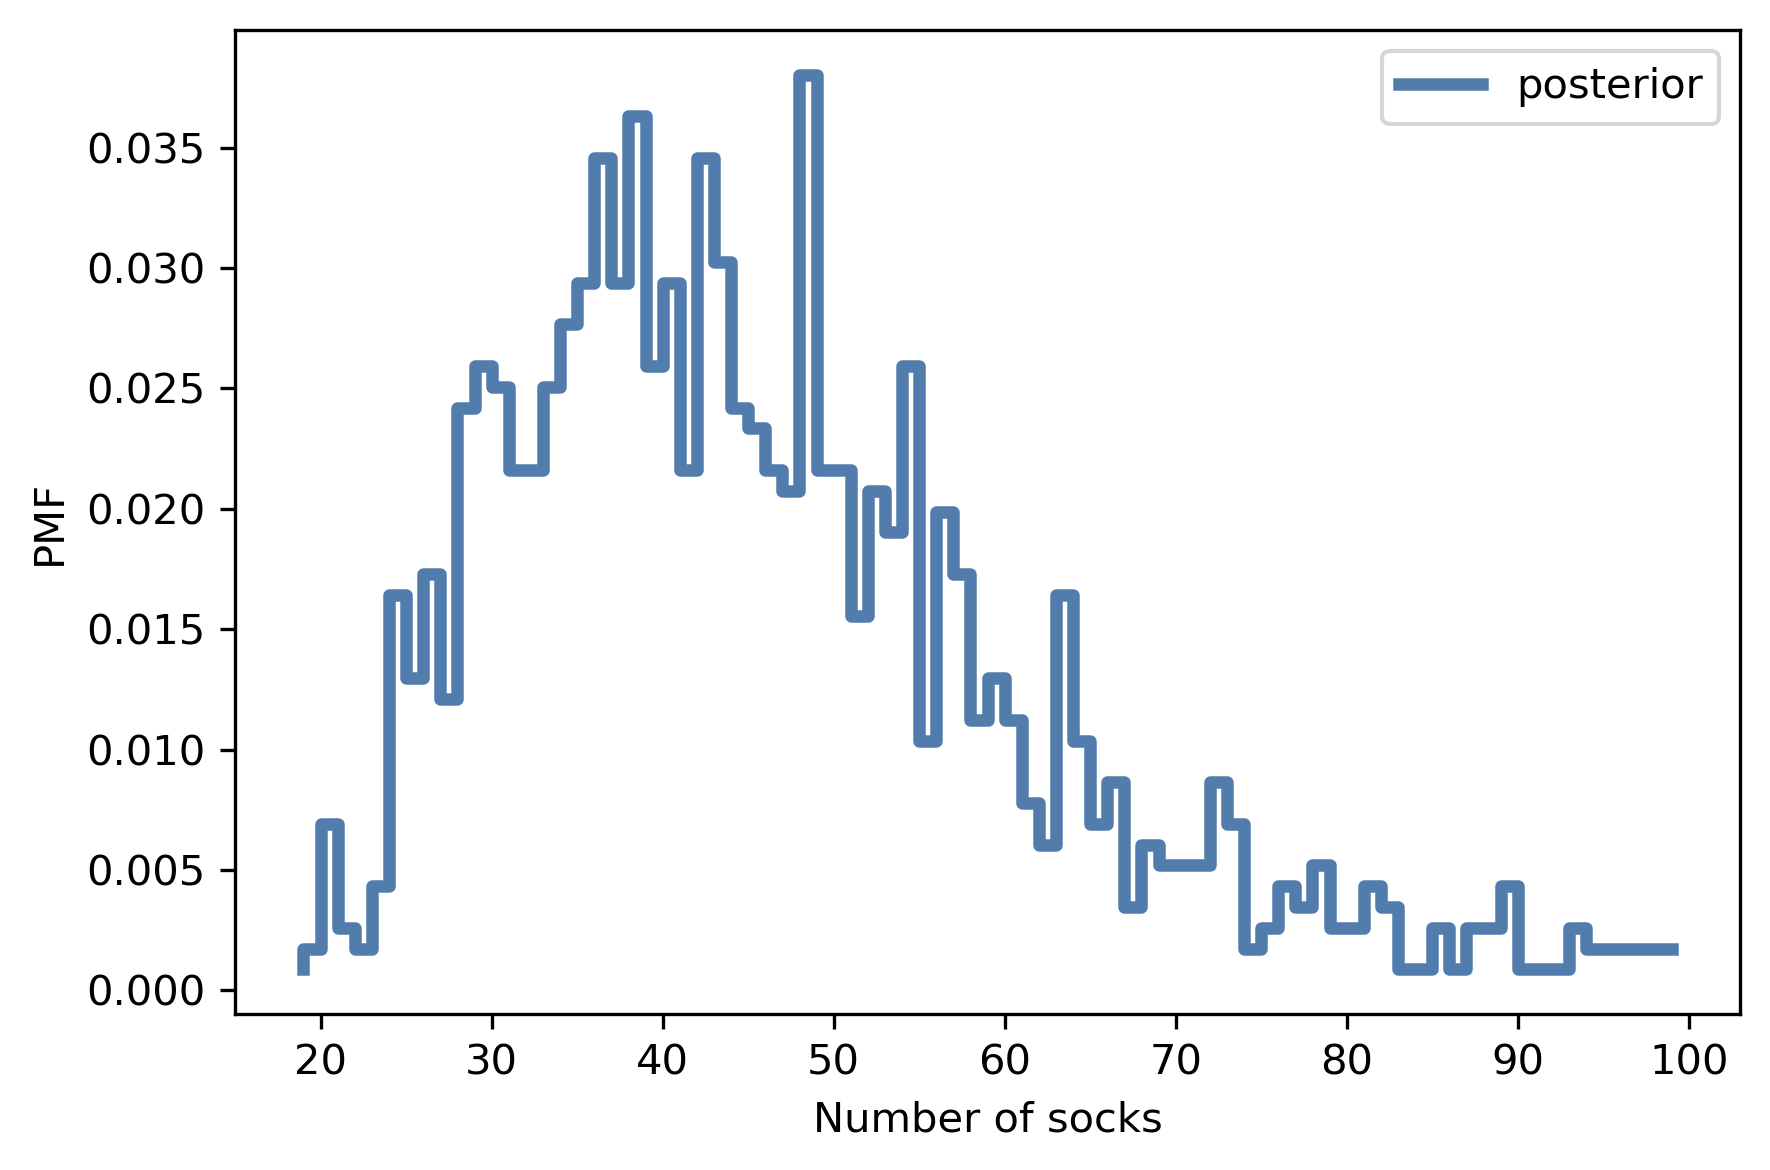

In [69]:
# Solution

posterior_n_socks.plot(label='posterior', drawstyle='steps')

decorate(xlabel='Number of socks',
         ylabel='PMF')